In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import diags
from math import floor

data = pd.read_csv('./heat_values.csv')
data = data.to_numpy()
data = np.flip(data)


with open('./heat_stats.txt', 'r') as f:
    for line in f:
        print(line)

shape = data.shape
pixelDim = np.sqrt(0.0048) #cm
lenX = pixelDim*shape[1] #cm
lenY = pixelDim*shape[0] #cm

print(pixelDim)

              Statistic [units]                 Plate Boundary                               

                     Mean [°C]                           35.3                               

                Std. Dev. [°C]                            4.4                               

                   Center [°C]            (178.0, 135.0) 34.3                               

                  Maximum [°C]                (269, 213) 45.1                               

                  Minimum [°C]                (168,  43) 23.4                               

               Number of Pixels                          34225                               

       Single Pixel Area [cm²]                         0.0048                               

                    Area [cm²]                          163.6                               

                    Length [cm]                            N/A                               

                     Emissivity                          

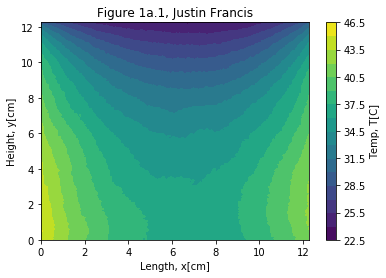

In [153]:
# fig 1a
X = np.linspace(0, lenX, shape[1])
Y = np.linspace(0, lenY, shape[0])

plt.figure(1)
plt.title('Figure 1a.1, Justin Francis')
plt.ylabel('Height, y[cm]')
plt.xlabel('Length, x[cm]')
plt.contourf(X, Y, data, 20)
cbar = plt.colorbar()
cbar.set_label('Temp, T[C]')
plt.savefig('Fig1a1.png')
plt.show()

In [154]:
#finding the boundary flux
qL = np.zeros(shape[0])
qR = np.zeros(shape[0])
k = 10 #W/mK NEED TO USE ACTUAL VAL
t = 0.318 #cm
t = t*1e-2 #m
pixelDim = pixelDim * 1e-2 #m

for row in range(shape[0]):
    qL[row] = -k*((-data[row,2] + (4*data[row,1]) - (3*data[row,0]))/(2*pixelDim))
    qR[row] = -k*(((3*data[row,-1]) - (4*data[row,-2]) + data[row,-3])/(2*pixelDim))

qT = np.zeros(shape[1])
qB = np.zeros(shape[1])
for col in range(shape[1]):
    qB[col] = -k*((-data[2,col] + (4*data[1,col]) - (3*data[0,col]))/(2*pixelDim))
    qT[col] = -k*(((3*data[-1, col]) - (4*data[-2, col]) + data[-3,col])/(2*pixelDim))
    
QL = t*np.trapz(qL, Y)
QR = t*np.trapz(qR, Y)
QT = t*np.trapz(qT, X)
QB = t*np.trapz(qB, X)

print(QL)
print(QR)
print(QT)
print(QB)


-19.26836079545477
-122.96572159090965
213.79085795454563
-20.627539772726852


In [90]:
#numerical analysis
# bound cond
TL = data[:,0] #at every point y
TR = data[:,-1] #at every point y
TT = data[-1,:] #at every point x
dTdyB = np.zeros(len(TT)) #everywhere

TB = np.zeros(len(TT))
TB[0] = TL[-1]
TB[-1] = TR[-1]
for i in range(1,len(TT)-1):
    TB[i] = 0.25 * (data[-1,i-1] + data[-1,i+1] + 2*data[-2,i])

print(data[-1,:])

[28.5 28.7 28.5 28.3 28.3 28.2 27.9 27.8 27.7 27.4 27.4 27.5 27.4 27.4
 27.1 27.2 27.  26.7 26.6 26.6 26.5 26.2 26.2 26.1 26.1 25.9 25.8 25.8
 25.7 25.6 25.4 25.3 25.2 25.2 25.1 25.1 25.1 24.9 24.7 24.8 24.7 24.8
 24.7 24.4 24.7 24.6 24.4 24.5 24.4 24.4 24.3 24.4 24.1 24.2 24.1 24.1
 24.1 24.  24.  23.9 24.  24.  24.  24.  24.2 23.9 24.  23.8 23.8 23.9
 23.9 23.8 23.8 23.8 23.8 23.8 23.9 23.8 23.9 23.8 23.8 23.8 23.8 23.7
 23.8 23.8 23.6 23.7 23.7 23.7 23.7 23.7 23.7 23.6 23.7 23.7 23.5 23.7
 23.7 23.7 23.8 23.6 23.6 23.8 23.7 23.7 23.8 23.6 23.8 23.8 23.8 23.8
 23.8 23.8 23.8 23.9 23.8 23.8 23.9 23.9 23.8 24.  24.  23.9 24.  23.9
 24.  24.  24.2 24.2 24.2 24.1 24.3 24.3 24.3 24.4 24.4 24.5 24.6 24.5
 24.7 24.8 24.8 24.8 25.  25.  25.2 25.2 25.2 25.3 25.5 25.5 25.6 25.7
 25.9 26.  26.  26.2 26.2 26.5 26.7 26.6 27.  27.1 27.1 27.4 27.4 27.5
 27.7 27.9 28.1 28.1 28.5 28.5 28.8 29.1 29.5]


In [43]:
# create mesh and A, C matrices
numElem = shape[0] * shape[1]
print("numElem: ", numElem)
numCol = floor(np.sqrt(numElem))
numRow = numCol #####
mainDiag = np.ones(numElem) * 4 
superDiag = np.ones(numElem-1) * -1
subDiag = np.ones(numElem-1) * -1
superDiag2 = np.ones(numElem-numCol) * -1
subDiag2 = np.ones(numElem-numCol) * -1
C = np.zeros(numElem)

for i in range(1,numCol):
    superDiag[(i*numCol)-1] = 0
    subDiag[(i*numCol)-1] = 0

for i in range(numCol):
    superDiag2[i] = -2
    C[i*numCol] = TL[i]
    C[(i*numCol)+(numCol-1)] = TR[i] ###
    if i != 0:
        C[-i] = TT[i]
    
C[numElem - numCol] = TT[0] + TR[0]
C[-1] = TT[-1] + TL[0]
    
A = diags([mainDiag, superDiag, subDiag, superDiag2, subDiag2], [0,1,-1,numCol, -numCol])

# print("A: ", A.todense())
# print("C: ", C)
# print('super: ', superDiag)
# print('sub: ', subDiag)
# print('super2: ', superDiag2)
# print(TL[-1])

numElem:  31329


In [44]:
# solve for T
T = np.linalg.solve(A.toarray(),C)

print('Finished...')

Finished...


(177, 177)


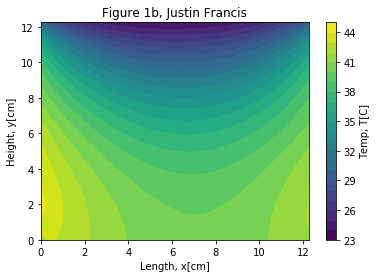

In [45]:
#plot
numericalData = np.zeros((numCol, numRow))
idx = 0
for i in range(numRow):
    for j in range(numCol):
        numericalData[i,j] = T[idx]
        idx += 1

print(numericalData.shape)

numX = np.linspace(0,lenX, numCol)
numY = np.linspace(0, lenY, numRow)

plt.figure(2)
plt.title('Figure 1b, Justin Francis')
plt.ylabel('Height, y[cm]')
plt.xlabel('Length, x[cm]')
plt.contourf(numX, numY, numericalData, 20)
cbar = plt.colorbar()
cbar.set_label('Temp, T[C]')
plt.savefig('Fig1b.png', dpi=800)
plt.show()

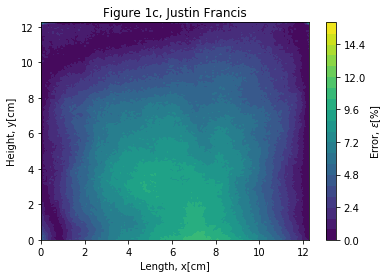

In [48]:
# 1c err in num sim
err = np.zeros((numRow,numCol))
for i in range(shape[0]):
    for j in range(shape[1]):
        err[i,j] = abs(data[i,j] - numericalData[i,j])/data[i,j] * 100

plt.figure(3)
plt.title('Figure 1c, Justin Francis')
plt.ylabel('Height, y[cm]')
plt.xlabel('Length, x[cm]')
plt.contourf(numX, numY, err, 20)
cbar = plt.colorbar()
cbar.set_label('Error, $\epsilon$[%]')
plt.savefig('Fig1c.png', dpi=800)
plt.show()

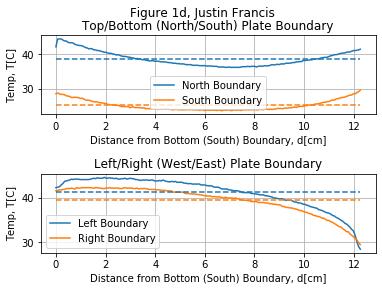

In [72]:
#1d
meanTT = np.mean(data[0,:])
meanTB = np.mean(data[-1,:])
meanTL = np.mean(data[:,0])
meanTR = np.mean(data[:,-1])

fig, axs = plt.subplots(2)
fig.suptitle('Figure 1d, Justin Francis')
plt.subplots_adjust(hspace=0.75)
axs[1].plot(numY, data[:,0], 'C0', label='Left Boundary')
axs[1].plot(numY, data[:,-1], 'C1', label='Right Boundary')
axs[1].plot([min(numY),max(numY)], [meanTR,meanTR], '--C1')
axs[1].plot([min(numY),max(numY)], [meanTL,meanTL], '--C0')
axs[0].plot(numX, data[0,:], 'C0', label='North Boundary')
axs[0].plot(numX, data[-1,:], 'C1', label='South Boundary')
axs[0].plot([min(numX),max(numX)], [meanTB,meanTB], '--C1')
axs[0].plot([min(numX),max(numX)], [meanTT,meanTT], '--C0')
axs[1].set_title('Left/Right (West/East) Plate Boundary')
axs[0].set_title('Top/Bottom (North/South) Plate Boundary')

for ax in axs.flat:
    ax.set(xlabel='Distance from Bottom (South) Boundary, d[cm]', ylabel='Temp, T[C]')
    ax.grid()
    ax.legend()
    
plt.savefig('Fig1d.png', dpi = 800)

In [159]:
# short answ
print('err max: ', np.amax(err))
print('err avg: ', np.mean(err))
print('err max loc: ', np.argwhere(err > 15.46))
print('ratio of std/mean [T, B, L, R]: ', 2*np.std(TT)/meanTT * 100, 2*np.std(TB)/meanTB * 100, 2*np.std(TL)/meanTL * 100, 2*np.std(TR)/meanTR * 100)

eta_cool = 0.15 #%
eta_heat = 0.95 #%
calc_power_T = QT/eta_cool
calc_power_L = -QL/eta_heat
calc_power_R = -QR/eta_heat
meas_pow_L = 24.7 #W
meas_pow_R = 34.2 #W
print('meas L R ', meas_pow_L, meas_pow_R)
print('calc L R ', calc_power_L, calc_power_R)
print('diff pow [l,r]: ', abs(meas_pow_L-calc_power_L)/meas_pow_L*100, abs(meas_pow_R-calc_power_R)/meas_pow_R*100  )
print('calc pow [t,l,r]: ', calc_power_T, calc_power_L, calc_power_R)

err max:  15.467554032116881
err avg:  4.53292220296842
err max loc:  [[176   0]]
ratio of std/mean [T, B, L, R]:  7.985100099305513 12.727597893590998 16.432482273557603 15.538876482048558
meas L R  24.7 34.2
calc L R  20.28248504784713 129.43760167464174
diff pow [l,r]:  17.88467591964725 278.4725195164963
calc pow [t,l,r]:  1425.2723863636377 20.28248504784713 129.43760167464174
